In [2]:
import random
import polars as pl
from pymongo import MongoClient
from datetime import datetime
from pymongo import InsertOne
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import contextily as ctx

In [3]:
# Conectar a MongoDB
client = MongoClient("mongodb://localhost:27017/")
database = client["ETIB_TFM"]
collection = database["transactions"]

In [4]:
# Rango de fechas
start_date = datetime(2024, 11, 11)
end_date = datetime(2024, 11, 18)

# Obtener los datos de MongoDB
query = {"Fecha_Transaccion": {"$gte": start_date, "$lt": end_date}}
cursor = collection.find(query)

# Convertir los datos a un DataFrame de Polars
df_polars = pl.DataFrame(cursor)

# Mostrar las primeras filas del DataFrame
print(df_polars.head())

shape: (5, 23)
┌────────────────┬─────────────┬────────────────┬────────────────┬───┬───────────────┬────────┬───────────────┬────────┐
│ _id            ┆ Dispositivo ┆ Emisor         ┆ Estacion_Parad ┆ … ┆ Tipo_Vehiculo ┆ Valor  ┆ archivo       ┆ cenefa │
│ ---            ┆ ---         ┆ ---            ┆ a              ┆   ┆ ---           ┆ ---    ┆ ---           ┆ ---    │
│ object         ┆ str         ┆ str            ┆ ---            ┆   ┆ str           ┆ f64    ┆ str           ┆ str    │
│                ┆             ┆                ┆ str            ┆   ┆               ┆        ┆               ┆        │
╞════════════════╪═════════════╪════════════════╪════════════════╪═══╪═══════════════╪════════╪═══════════════╪════════╡
│ 67471e1df909cb ┆ 220004413   ┆ (3101000)      ┆ (52973) 045A06 ┆ … ┆ (02) Urbano   ┆ 0.0    ┆ Validacion_01 ┆ 045A06 │
│ e620eb3347     ┆             ┆ Bogota         ┆ _TM|045A06_Br. ┆   ┆               ┆        ┆ 7_E-SOMOS     ┆        │
│                

In [5]:
df_polars.schema

Schema([('_id', Object),
        ('Dispositivo', String),
        ('Emisor', String),
        ('Estacion_Parada', String),
        ('Fase', String),
        ('Fecha_Clearing', String),
        ('Fecha_Transaccion', Datetime(time_unit='us', time_zone=None)),
        ('Hora_Pico_SN', String),
        ('ID_Vehiculo', String),
        ('Linea', String),
        ('Nombre_Perfil', String),
        ('Numero_Tarjeta', String),
        ('Operador', String),
        ('Ruta', String),
        ('Saldo_Despues_Transaccion', Float64),
        ('Saldo_Previo_a_Transaccion', Float64),
        ('Sistema', String),
        ('Tipo_Tarifa', String),
        ('Tipo_Tarjeta', String),
        ('Tipo_Vehiculo', String),
        ('Valor', Float64),
        ('archivo', String),
        ('cenefa', String)])

In [6]:
df_polars.select(pl.col("*").is_null().sum())    

_id,Dispositivo,Emisor,Estacion_Parada,Fase,Fecha_Clearing,Fecha_Transaccion,Hora_Pico_SN,ID_Vehiculo,Linea,Nombre_Perfil,Numero_Tarjeta,Operador,Ruta,Saldo_Despues_Transaccion,Saldo_Previo_a_Transaccion,Sistema,Tipo_Tarifa,Tipo_Tarjeta,Tipo_Vehiculo,Valor,archivo,cenefa
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df_polars.describe()

statistic,_id,Dispositivo,Emisor,Estacion_Parada,Fase,Fecha_Clearing,Fecha_Transaccion,Hora_Pico_SN,ID_Vehiculo,Linea,Nombre_Perfil,Numero_Tarjeta,Operador,Ruta,Saldo_Despues_Transaccion,Saldo_Previo_a_Transaccion,Sistema,Tipo_Tarifa,Tipo_Tarjeta,Tipo_Vehiculo,Valor,archivo,cenefa
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,f64,str,str
"""count""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""","""11253225""",1.1253225e7,1.1253225e7,"""11253225""","""11253225""","""11253225""","""11253225""",1.1253225e7,"""11253225""","""11253225"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,"""2024-11-14 10:15:05.113333""",null,null,null,null,null,null,null,12984.382108,14981.481501,null,null,null,null,2174.861597,null,null
"""std""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,19212.327645,19331.902302,null,null,null,null,1248.936226,null,null
"""min""",null,"""22""","""(3101000) Bogota Card(Citizen)""","""(49841) 080A01_TM|080A01_Br. L…","""Fase 3""","""2024-11-10""","""2024-11-11 00:00:10""","""Peak Time""","""102018""","""(10001) 17-3 Modelia""","""(001) Adulto""","""000001c59b6d6c4e76c2b25f63cf52…","""(001) CONSORCIO EXPRESS USAQUE…","""(10004) HH710_V1""",0.0,0.0,"""ZONAL""","""1""","""tullave Básica""","""(02) Urbano""",0.0,"""Validacion_001_CONSORCIO EXPRE…","""001A00"""
"""25%""",null,null,null,null,null,null,"""2024-11-12 22:09:37""",null,null,null,null,null,null,null,2300.0,4450.0,null,null,null,null,2500.0,null,null
"""50%""",null,null,null,null,null,null,"""2024-11-14 09:09:49""",null,null,null,null,null,null,null,6900.0,9150.0,null,null,null,null,2950.0,null,null
"""75%""",null,null,null,null,null,null,"""2024-11-15 16:45:07""",null,null,null,null,null,null,null,15750.0,17950.0,null,null,null,null,2950.0,null,null
"""max""",null,"""220009981""","""(3200901) Banco de Bogotá""","""(73939) 668A13|668A13_Br. Alto…","""Fase 3""","""2024-11-17""","""2024-11-17 23:58:05""","""Peak Time""","""937211""","""(1684) GH543""","""(101) Adulto PV""","""fffff6d484cfcd0551cc32b5862517…","""(134) OPERADORA DISTRITAL DE T…","""(8287) GH543_20241117_Ciclov�V…",418000.0,418000.0,"""ZONAL""","""3""","""tullave Plus""","""(02) Urbano""",2950.0,"""Validacion_134_OPERADORA DISTR…","""TC6Dora"""


In [8]:
df_polars = df_polars.with_columns(
    pl.col('Fecha_Transaccion').dt.hour().alias('Hora')
)

In [9]:
cnames = {
'aqua': '#00FFFF',
'aquamarine': '#7FFFD4',
'bisque': '#FFE4C4',
'black': '#000000',
'blanchedalmond': '#FFEBCD',
'blue': '#0000FF',
'blueviolet': '#8A2BE2',
'brown': '#A52A2A',
'burlywood': '#DEB887',
'cadetblue': '#5F9EA0',
'chartreuse': '#7FFF00',
'chocolate': '#D2691E',
'coral': '#FF7F50',
'cornflowerblue': '#6495ED',
'crimson': '#DC143C',
'cyan': '#00FFFF',
'darkblue': '#00008B',
'darkcyan': '#008B8B',
'darkgoldenrod': '#B8860B',
'darkgray': '#A9A9A9',
'darkgreen': '#006400',
'darkkhaki': '#BDB76B',
'darkmagenta': '#8B008B',
'darkolivegreen': '#556B2F',
'darkorange': '#FF8C00',
'darkorchid': '#9932CC',
'darkred': '#8B0000',
'darksalmon': '#E9967A',
'darkseagreen': '#8FBC8F',
'darkslateblue': '#483D8B',
'darkslategray': '#2F4F4F',
'darkturquoise': '#00CED1',
'darkviolet': '#9400D3',
'deeppink': '#FF1493',
'deepskyblue': '#00BFFF',
'dodgerblue': '#1E90FF',
'firebrick': '#B22222',
'forestgreen': '#228B22',
'fuchsia': '#FF00FF',
'gainsboro': '#DCDCDC',
'gold': '#FFD700',
'goldenrod': '#DAA520',
'gray': '#808080',
'green': '#008000',
'greenyellow': '#ADFF2F',
'hotpink': '#FF69B4',
'indianred': '#CD5C5C',
'indigo': '#4B0082',
'khaki': '#F0E68C',
'lavender': '#E6E6FA',
'lawngreen': '#7CFC00',
'lightcoral': '#F08080',
'lightcyan': '#E0FFFF',
'lightgreen': '#90EE90',
'lightsalmon': '#FFA07A',
'lightseagreen': '#20B2AA',
'lightskyblue': '#87CEFA',
'lightsteelblue': '#B0C4DE',
'lime': '#00FF00',
'limegreen': '#32CD32',
'linen': '#FAF0E6',
'magenta': '#FF00FF',
'maroon': '#800000',
'mediumaquamarine': '#66CDAA',
'mediumblue': '#0000CD',
'mediumorchid': '#BA55D3',
'mediumpurple': '#9370DB',
'mediumseagreen': '#3CB371',
'mediumslateblue': '#7B68EE',
'mediumspringgreen': '#00FA9A',
'mediumturquoise': '#48D1CC',
'mediumvioletred': '#C71585',
'midnightblue': '#191970',
'mistyrose': '#FFE4E1',
'moccasin': '#FFE4B5',
'navy': '#000080',
'olive': '#808000',
'olivedrab': '#6B8E23',
'orange': '#FFA500',
'orangered': '#FF4500',
'orchid': '#DA70D6',
'palegoldenrod': '#EEE8AA',
'palegreen': '#98FB98',
'paleturquoise': '#AFEEEE',
'palevioletred': '#DB7093',
'papayawhip': '#FFEFD5',
'peachpuff': '#FFDAB9',
'peru': '#CD853F',
'pink': '#FFC0CB',
'plum': '#DDA0DD',
'powderblue': '#B0E0E6',
'purple': '#800080',
'red': '#FF0000',
'rosybrown': '#BC8F8F',
'royalblue': '#4169E1',
'saddlebrown': '#8B4513',
'salmon': '#FA8072',
'sandybrown': '#FAA460',
'seagreen': '#2E8B57',
'sienna': '#A0522D',
'silver': '#C0C0C0',
'skyblue': '#87CEEB',
'slateblue': '#6A5ACD',
'slategray': '#708090',
'springgreen': '#00FF7F',
'steelblue': '#4682B4',
'tan': '#D2B48C',
'teal': '#008080',
'thistle': '#D8BFD8',
'tomato': '#FF6347',
'turquoise': '#40E0D0',
'violet': '#EE82EE',
'yellow': '#FFFF00',
'yellowgreen': '#9ACD32'}
colors = list(cnames.keys())

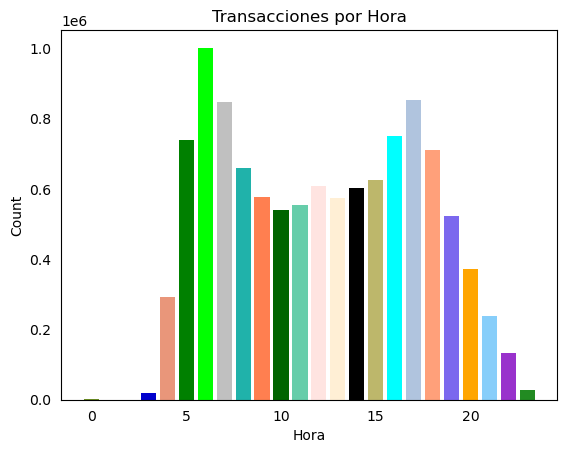

In [10]:
random.shuffle(colors)
un, count = np.unique(df_polars['Hora'],return_counts=True)
plt.title("Transacciones por Hora")
plt.xlabel("Hora")
plt.ylabel("Count")
plt.tick_params(bottom=False,left=False)
plt.bar(un,count,color=colors)
plt.show()

In [11]:
# Extraer el año, mes y día de la columna 'Fecha_Transaccion'
df_polars = df_polars.with_columns([
    pl.col("Fecha_Transaccion").dt.year().alias("Año"),
    pl.col("Fecha_Transaccion").dt.month().alias("Mes"),
    pl.col("Fecha_Transaccion").dt.day().alias("Día")
])

# Crear una nueva columna que combine Año, Mes y Día como un string (si lo deseas)
df_polars = df_polars.with_columns(
    (pl.col("Año").cast(pl.Utf8) + "-" +
     pl.col("Mes").cast(pl.Utf8).str.zfill(2) + "-" +
     pl.col("Día").cast(pl.Utf8).str.zfill(2)).alias("Fecha")
)

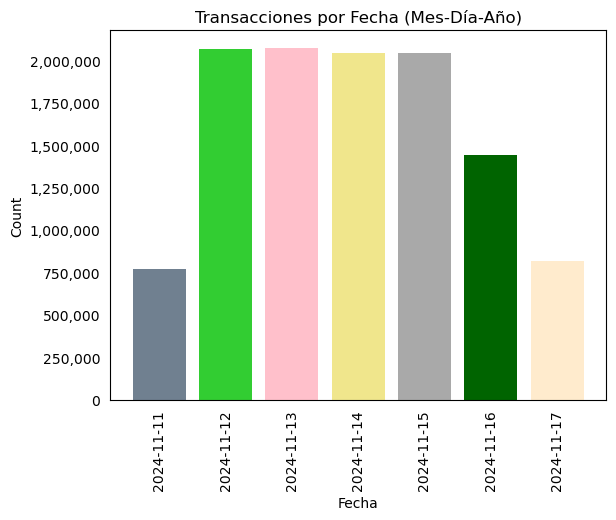

In [12]:
random.shuffle(colors)
un, count = np.unique(df_polars['Fecha'],return_counts=True)
plt.title("Transacciones por Fecha (Mes-Día-Año)")
plt.xlabel("Fecha")
plt.ylabel("Count")
plt.tick_params(bottom=False,left=False)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.bar(un,count,color=colors)
plt.xticks(rotation=90)
plt.show()

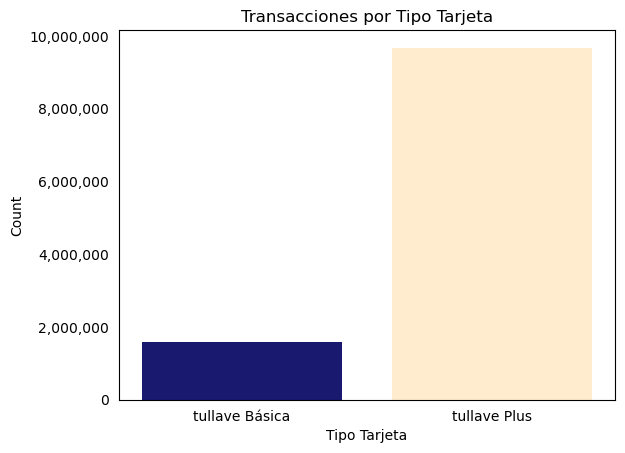

In [12]:
random.shuffle(colors)
un, count = np.unique(df_polars['Tipo_Tarjeta'],return_counts=True)
plt.title("Transacciones por Tipo Tarjeta")
plt.xlabel("Tipo Tarjeta")
plt.ylabel("Count")
plt.tick_params(bottom=False,left=False)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.bar(un,count,color=colors)
plt.show()

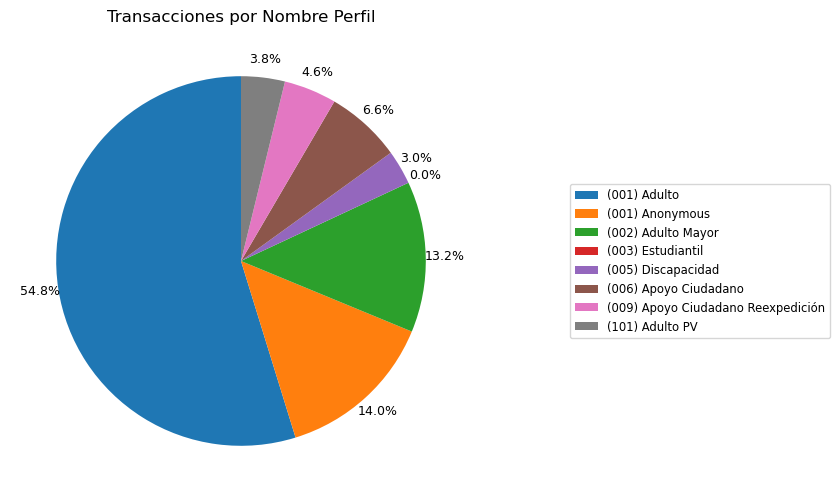

In [13]:
# Obtener los valores únicos y sus conteos
un, count = np.unique(df_polars['Nombre_Perfil'], return_counts=True)

# Crear el gráfico de pastel
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.pie(count, labels=None, autopct='%1.1f%%', startangle=90, labeldistance=.6, textprops={'fontsize': 9},  pctdistance=1.10)

# Título del gráfico
plt.title("Transacciones por Nombre Perfil")

# Colocar la leyenda por fuera
plt.legend(un, loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize='small')  # Ajusta la posición de la leyenda

# Mostrar el gráfico
plt.show()

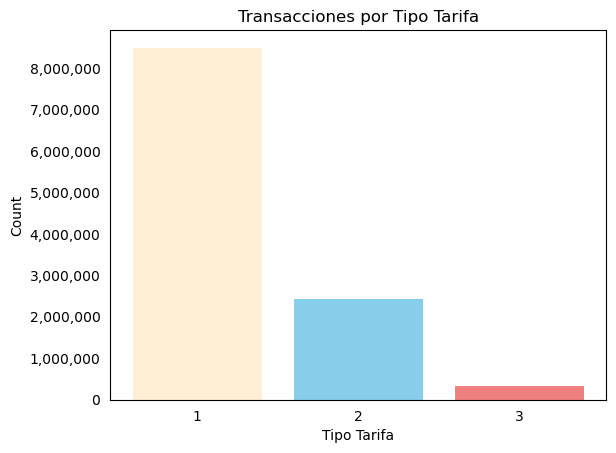

In [14]:
random.shuffle(colors)
un, count = np.unique(df_polars['Tipo_Tarifa'],return_counts=True)
plt.title("Transacciones por Tipo Tarifa")
plt.xlabel("Tipo Tarifa")
plt.ylabel("Count")
plt.tick_params(bottom=False,left=False)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.bar(un,count,color=colors)
plt.show()

In [15]:
cursorStops = list(database.bus_stops.find({}, {"cenefa": 1, "longitud_paradero": 1, "latitud_paradero": 1, "_id": 0}))

# Convertir el resultado a un DataFrame de Polars
df_busStops = pl.DataFrame(cursorStops)

In [16]:
df_busStops.describe()

statistic,cenefa,longitud_paradero,latitud_paradero
str,str,f64,f64
"""count""","""7699""",7699.0,7699.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,-74.109088,4.640245
"""std""",null,0.043989,0.067816
"""min""","""001A00""",-74.215145,4.404931
"""25%""",null,-74.141982,4.591301
"""50%""",null,-74.108588,4.633864
"""75%""",null,-74.077458,4.693443
"""max""","""BD-066A""",-74.013119,4.820427


In [17]:
df_busStops.schema

Schema([('cenefa', String),
        ('longitud_paradero', Float64),
        ('latitud_paradero', Float64)])

In [18]:
df_busStops.select(pl.col("*").is_null().sum())

cenefa,longitud_paradero,latitud_paradero
u32,u32,u32
0,0,0


In [19]:
df_merge = df_polars.join(df_busStops, on="cenefa", how="left")

In [20]:
df_merge.schema

Schema([('_id', Object),
        ('Dispositivo', String),
        ('Emisor', String),
        ('Estacion_Parada', String),
        ('Fase', String),
        ('Fecha_Clearing', String),
        ('Fecha_Transaccion', Datetime(time_unit='us', time_zone=None)),
        ('Hora_Pico_SN', String),
        ('ID_Vehiculo', String),
        ('Linea', String),
        ('Nombre_Perfil', String),
        ('Numero_Tarjeta', String),
        ('Operador', String),
        ('Ruta', String),
        ('Saldo_Despues_Transaccion', Float64),
        ('Saldo_Previo_a_Transaccion', Float64),
        ('Sistema', String),
        ('Tipo_Tarifa', String),
        ('Tipo_Tarjeta', String),
        ('Tipo_Vehiculo', String),
        ('Valor', Float64),
        ('archivo', String),
        ('cenefa', String),
        ('Hora', Int8),
        ('Año', Int32),
        ('Mes', Int8),
        ('Día', Int8),
        ('Fecha', String),
        ('longitud_paradero', Float64),
        ('latitud_paradero', Float64)])

In [21]:
print(df_merge.select([
    pl.col("longitud_paradero").null_count().alias("longitud_paradero_nulos"),
    pl.col("latitud_paradero").null_count().alias("latitud_paradero_nulos"),
    pl.col("Ruta").null_count().alias("Ruta_nulos")
]))

shape: (1, 3)
┌─────────────────────────┬────────────────────────┬────────────┐
│ longitud_paradero_nulos ┆ latitud_paradero_nulos ┆ Ruta_nulos │
│ ---                     ┆ ---                    ┆ ---        │
│ u32                     ┆ u32                    ┆ u32        │
╞═════════════════════════╪════════════════════════╪════════════╡
│ 249239                  ┆ 249239                 ┆ 0          │
└─────────────────────────┴────────────────────────┴────────────┘


In [22]:
df_merge_clean = df_merge.drop_nulls(subset=['longitud_paradero', 'latitud_paradero', 'Ruta'])

In [23]:
shapefile = gpd.read_file('../maps/Loca.shp')
shapefile
shapefile_filtered = shapefile[~shapefile['LocNombre'].isin(['USME', 'SUMAPAZ','CIUDAD BOLIVAR'])]
shapefile_filtered

,LocNombre,LocAAdmini,LocArea,LocCodigo,SHAPE_Leng,SHAPE_Area,geometry
0,ANTONIO NARIÑO,Acuerdo 117 de 2003,4.879543e+06,15,0.108973,0.000397,"POLYGON ((-74.13075 4.59335, -74.12917 4.59327..."
1,TUNJUELITO,Acuerdo 117 de 2003,9.910940e+06,06,0.210542,0.000807,"POLYGON ((-74.13777 4.59489, -74.13165 4.59363..."
2,RAFAEL URIBE URIBE,Acuerdo 117 de 2003,1.383408e+07,18,0.174513,0.001126,"POLYGON ((-74.12803 4.59254, -74.12777 4.59233..."
3,CANDELARIA,Acuerdo 117 de 2003,2.060243e+06,17,0.067158,0.000168,"POLYGON ((-74.06621 4.60317, -74.0662 4.60317,..."
4,BARRIOS UNIDOS,Acuerdo 8 de 1977,1.190345e+07,12,0.121180,0.000969,"POLYGON ((-74.05725 4.68684, -74.06249 4.65594..."
5,TEUSAQUILLO,Acuerdo 8 de 1977,1.419317e+07,13,0.148314,0.001156,"POLYGON ((-74.09372 4.66607, -74.09332 4.66574..."
6,PUENTE ARANDA,Acuerdo 8 de 1977,1.731115e+07,16,0.161116,0.001410,"POLYGON ((-74.1183 4.63741, -74.11504 4.64053,..."
7,LOS MARTIRES,Acuerdo 8 de 1977,6.514046e+06,14,0.099382,0.000530,"POLYGON ((-74.07283 4.61542, -74.07311 4.6148,..."
9,USAQUEN,Acuerdo 8 de 1977 y Res 1751 de 2016,6.520141e+07,01,0.436907,0.005310,"POLYGON ((-74.01116 4.66459, -74.01117 4.6646,..."
10,CHAPINERO,Acuerdo 8 de 1977 y Res 1751 de 2016,3.800891e+07,02,0.333966,0.003095,"POLYGON ((-74.01116 4.66459, -74.01154 4.66461..."


In [24]:
# Cargar el shapefile de Bogotá
shapefile = shapefile_filtered

# Filtrar las transacciones por las 20 rutas más transaccionadas
route_counts = df_merge_clean.group_by('Ruta').count()
route_counts = route_counts.sort('count', descending=True)

# Seleccionar las primeras 20 rutas con mayor número de transacciones
top_10_routes = route_counts.head(10)['Ruta']

# Filtrar el DataFrame original para mantener solo las rutas top 10
df_top_10 = df_merge_clean.filter(df_merge_clean['Ruta'].is_in(top_10_routes))

# Eliminar duplicados
df_clean_unique = df_top_10.unique(subset=['Ruta', 'Fecha_Transaccion', 'cenefa', 'latitud_paradero', 'longitud_paradero'])

# Convertir a Pandas para usar con Matplotlib
df_clean_pandas = df_clean_unique.to_pandas()

# Asignar colores a las rutas
colors = cm.get_cmap('tab10', len(top_10_routes))  # Se asegura que haya suficientes colores para las 20 rutas

# Iterar sobre las 20 rutas para crear un mapa para cada una
for i, route in enumerate(top_10_routes):
    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(10, 8))

    # Dibujar el mapa base de Bogotá
    shapefile.plot(ax=ax, color='lightgreen', alpha=0.5)

    # Agregar la capa base de OpenStreetMap
    ctx.add_basemap(ax, crs=shapefile.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # Filtrar los datos de la ruta actual
    route_data = df_clean_pandas[df_clean_pandas['Ruta'] == route]

    # Graficar los puntos de paraderos para la ruta actual
    ax.scatter(route_data['longitud_paradero'], route_data['latitud_paradero'], 
               label=route, color=colors(i), alpha=0.7, s=10)

    # Añadir título y etiquetas
    ax.set_title(f"Puntos de paraderos para la ruta: {route}")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

    # Ajustar la leyenda para que no ocupe tanto espacio
    ax.legend(title="Rutas", loc='upper left', fontsize=8, bbox_to_anchor=(1.05, 1))

    # Mostrar el mapa
    plt.tight_layout()  # Ajustar el espacio para evitar recorte
    # Guardar la imagen como archivo PNG
    output_filename = f"../images/mapa_ruta_{route}.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')

    # Cerrar la figura después de guardarla
    plt.close(fig)

C:\Users\Gabo0\AppData\Local\Temp\ipykernel_11052\93147225.py:5: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  route_counts = df_merge_clean.group_by('Ruta').count()
C:\Users\Gabo0\AppData\Local\Temp\ipykernel_11052\93147225.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(top_10_routes))  # Se asegura que haya suficientes colores para las 20 rutas


In [38]:
# Crear la colección con validación de esquema para tu modelo de datos
database.create_collection("data_model", validator={
    "$jsonSchema": {
        "bsonType": "object",
        "required": [
            "Dispositivo", "Emisor", "Estacion_Parada", "Fase", "Fecha_Clearing",
            "Fecha_Transaccion", "Hora_Pico_SN", "ID_Vehiculo", "Linea", "Nombre_Perfil",
            "Numero_Tarjeta", "Operador", "Ruta", "Saldo_Despues_Transaccion", 
            "Saldo_Previo_a_Transaccion", "Sistema", "Tipo_Tarifa", "Tipo_Tarjeta",
            "Tipo_Vehiculo", "Valor", "archivo", "cenefa", "Hora", "Año", "Mes", "Día", 
            "Fecha", "longitud_paradero", "latitud_paradero"
        ],
        "properties": {
            "Dispositivo": {"bsonType": "string"},
            "Emisor": {"bsonType": "string"},
            "Estacion_Parada": {"bsonType": "string"},
            "Fase": {"bsonType": "string"},
            "Fecha_Clearing": {"bsonType": "string"},
            "Fecha_Transaccion": {"bsonType": "date"},  # Asegurando que sea de tipo fecha
            "Hora_Pico_SN": {"bsonType": "string"},
            "ID_Vehiculo": {"bsonType": "string"},
            "Linea": {"bsonType": "string"},
            "Nombre_Perfil": {"bsonType": "string"},
            "Numero_Tarjeta": {"bsonType": "string"},
            "Operador": {"bsonType": "string"},
            "Ruta": {"bsonType": "string"},
            "Saldo_Despues_Transaccion": {"bsonType": "double"},  # Usar "double" para valores numéricos decimales
            "Saldo_Previo_a_Transaccion": {"bsonType": "double"},
            "Sistema": {"bsonType": "string"},
            "Tipo_Tarifa": {"bsonType": "string"},
            "Tipo_Tarjeta": {"bsonType": "string"},
            "Tipo_Vehiculo": {"bsonType": "string"},
            "Valor": {"bsonType": "double"},
            "archivo": {"bsonType": "string"},
            "cenefa": {"bsonType": "string"},
            "Hora": {"bsonType": "int"},
            "Año": {"bsonType": "int"},
            "Mes": {"bsonType": "int"},
            "Día": {"bsonType": "int"},
            "Fecha": {"bsonType": "string"},
            "longitud_paradero": {"bsonType": "double"},
            "latitud_paradero": {"bsonType": "double"}
        }
    }
})

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ETIB_TFM'), 'data_model')

In [41]:
# Convertir el DataFrame de Polars a Pandas
df_top_10_pandas = df_top_10.to_pandas()

collection = database["data_model"]

# Tamaño del lote
batch_size = 10000

# Convierte el DataFrame a una lista de diccionarios
data_dict = df_top_10_pandas.to_dict("records")

# Inserta los documentos en lotes
for i in range(0, len(data_dict), batch_size):
    batch = data_dict[i:i + batch_size]
    requests = [InsertOne(doc) for doc in batch]
    try:
        result = collection.bulk_write(requests)
        print(f'Batch {i//batch_size + 1} inserted successfully.')
    except Exception as e:
        print(f'Error inserting batch {i//batch_size + 1}: {e}')


# Crear índice en la columna Fecha_Clearing (solo fecha)
collection.create_index([("Fecha_Transaccion", 1)])

Batch 1 inserted successfully.
Batch 2 inserted successfully.
Batch 3 inserted successfully.
Batch 4 inserted successfully.
Batch 5 inserted successfully.
Batch 6 inserted successfully.
Batch 7 inserted successfully.
Batch 8 inserted successfully.
Batch 9 inserted successfully.
Batch 10 inserted successfully.
Batch 11 inserted successfully.
Batch 12 inserted successfully.
Batch 13 inserted successfully.
Batch 14 inserted successfully.
Batch 15 inserted successfully.
Batch 16 inserted successfully.
Batch 17 inserted successfully.
Batch 18 inserted successfully.
Batch 19 inserted successfully.
Batch 20 inserted successfully.
Batch 21 inserted successfully.
Batch 22 inserted successfully.
Batch 23 inserted successfully.
Batch 24 inserted successfully.
Batch 25 inserted successfully.
Batch 26 inserted successfully.
Batch 27 inserted successfully.
Batch 28 inserted successfully.
Batch 29 inserted successfully.
Batch 30 inserted successfully.
Batch 31 inserted successfully.
Batch 32 inserted

'Fecha_Transaccion_1'